### Anomalies Detection on Health Insurance Claims

1. Exploratory Data Analysis
    + Features knowledge

The document is going to lead the distribution and insights about an important feature with valuable information involved on every claim, on a first study we shall make some assumptions from the DWH

### Average days of hospitalization

In [80]:
import os
import matplotlib as mpl
import numpy as np
import collections
import pandas as pd
from itertools import count
from pandas.core.window import Rolling
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')
%matplotlib inline

In [3]:
df = pd.read_csv("hospit-days.csv", parse_dates=True, sep=';')

In [5]:
df.head()

,In,Out,Days
0,27-12-17,30/12/2017,3
1,26-12-17,30/12/2017,4
2,27-12-17,30/12/2017,3
3,29-12-17,30/12/2017,1
4,26-12-17,30/12/2017,4


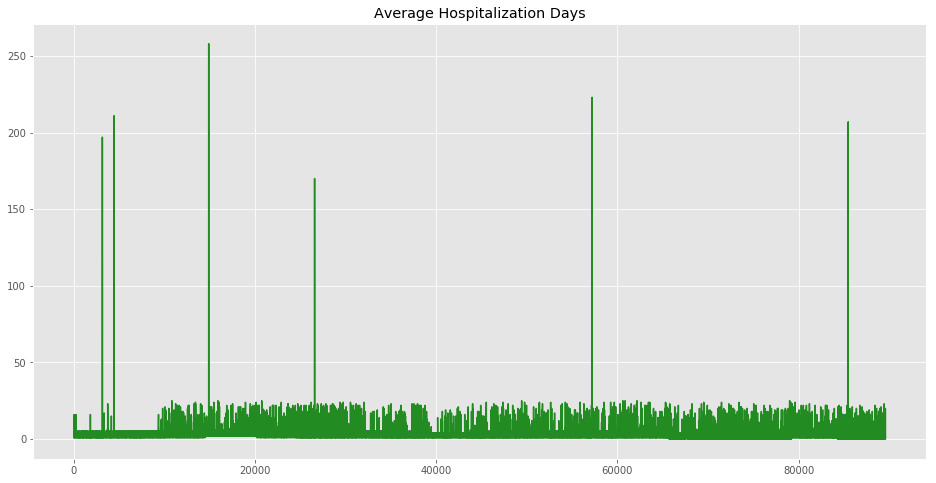

In [11]:
plt.figure(figsize=(16, 8))
plt.title("Average Hospitalization Days")
plt.plot(range(len(df)), df['Days'], '-', c='forestgreen')

In [19]:
df['In'] = pd.to_datetime(df['In'])
df['Out'] = pd.to_datetime(df['Out'])

In [20]:
#how the top looks like
df.sort_values(['Days'], ascending=False).head(10)

,In,Out,Days
14891,2014-03-13,2014-11-26,258
57204,2006-09-01,2006-08-20,223
4451,2016-02-08,2017-01-03,211
85473,2000-03-26,2000-10-19,207
3154,2016-12-11,2017-05-28,197
26577,2012-03-03,2012-08-20,170
60605,2005-12-20,2006-01-14,25
62163,2005-08-25,2005-09-19,25
20743,2013-10-20,2013-11-14,25
15917,2014-08-29,2014-09-23,25


In [21]:
months = df['In'].dt.to_period("M")
dfm = df.groupby(months).mean()

,Days
In,
1999-12,6.156250
2000-01,2.113684
2000-02,2.156716
2000-03,2.339806
2000-04,1.982843


In [22]:
dfm.head(10)

,Days
In,
1999-12,6.156250
2000-01,2.113684
2000-02,2.156716
2000-03,2.339806
2000-04,1.982843
2000-05,2.067720
2000-06,1.764706
2000-07,2.075426
2000-08,1.770302


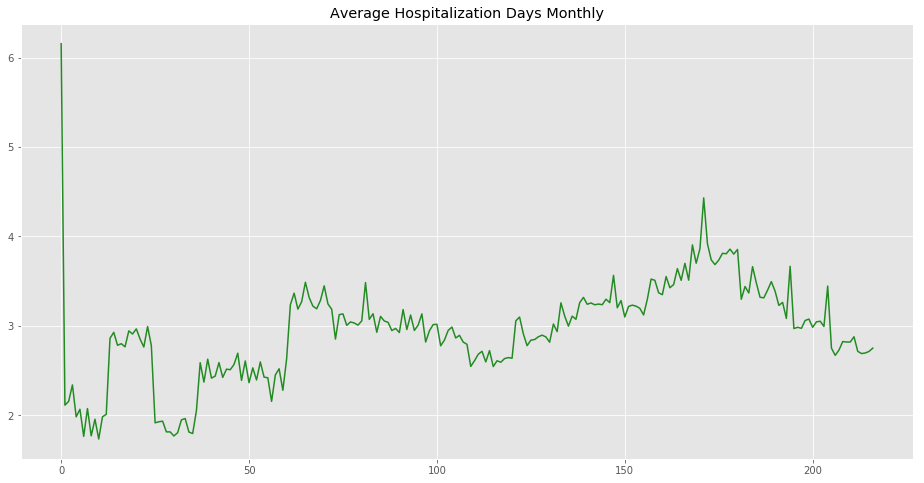

In [23]:
plt.figure(figsize=(16, 8))
plt.title("Average Hospitalization Days Monthly")
plt.plot(range(len(dfm)), dfm['Days'], '-', c='forestgreen')

In [24]:
dfy = df.groupby(df['In'].map(lambda x: x.year)).mean()

In [25]:
dfy.head(10)

,Days
In,
1999,6.156250
2000,1.997479
2001,2.860689
2002,1.880566
2003,2.512938
2004,2.450731
2005,3.287137
2006,3.074313
2007,3.034554


---
Trying to explain Anomalies [Anmoaly Detection](https://www.datascience.com/blog/python-anomaly-detection)

In [69]:
# 3. Lets define some use-case specific UDF(User Defined Functions)

def moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

def explain_anomalies(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in zip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = Rolling(residual, window_size).std()
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in zip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1, text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, len(y))
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

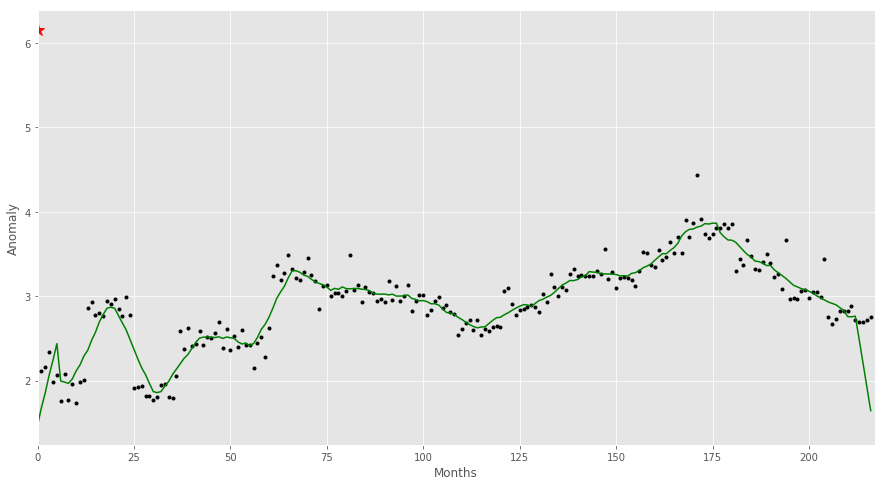

In [47]:
plot_results(range(len(dfm.index)), y=dfm['Days'], window_size=10, text_xlabel="Months", sigma_value=3, text_ylabel="Anomaly")

In [51]:
events = explain_anomalies(dfm['Days'], window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

Information about the anomalies model:{'standard_deviation': 0.322, 'anomalies_dict': OrderedDict([(0, 6.15625), (216, 2.751336898395722)])}


In [71]:
events_std = explain_anomalies_rolling_std(df['Days'], window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events_std))

Information about the anomalies model:{'stationary standard_deviation': 2.338, 'anomalies_dict': OrderedDict([(14270, 3), (14703, 2), (23097, 5), (27992, 2), (61410, 3), (65515, 3), (70581, 3), (79850, 3), (86224, 3), (88420, 3)])}


---

Now we now the outliers of days of hospitalization we have to see every single day what happened, we have to make a list of all those  

let's see now all the cases where is more than 1 year, it means (likely) is a system issue

In [72]:
#Not so many of those
df[df['Days'] > 365].count()

In      0
Out     0
Days    0
dtype: int64

In [73]:
df.describe()

,Days
count,89578.000000
mean,2.932003
std,2.670116
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,258.000000


In [75]:
#The rule we gonna use is excluding all the data with days more than 2 estandart deviatin_
two_dev = int(2*df['Days'].std())
two_dev

5

In [76]:
df_ = df[df['Days'] < two_dev]
df_.count()

In      81152
Out     81152
Days    81152
dtype: int64

In [83]:
#plt.figure(figsize=(16, 8))
#plt.title("Average Hospitalization Days")
#plt.plot(range(len(df_)), df_['Days'], '-', c='forestgreen')

What's the proportion of the information included within 2stddev

In [79]:
df_.count()/df.count()
#this is the percentage of the data contained within 2 standart deviation

In      0.905937
Out     0.905937
Days    0.905937
dtype: float64

##### Average days in history

The patients has 3+-3 days of hospitalization over the time.  

From here we may set some questions about it  

- Avg days grouped by disease
- Avg days grouped by age, gender
- Avg days grouped by participant (agent, doctor, ofice)
- Avg days grouped by season
     

This mean it makes more senese, and also one standart deviation hace to be close to zero

---

In order to have some insight about the time series we gonna wrang the dates

---
### Defining Boundary

The first thing we have to consider is the time.

So we define $ \Delta_{tr} $ as the time elapsed between 2 trials, where a trial is the event of push the buttom and select a digit on the test.

Thinking on this we say that every person perform $n$ number of tests and every test has $m$ number of trials, then the time elapsed to perform every trial is $ \Delta_{tr} $

We define $T$ as the vector of time responses on an event, following this logic we can calculate the median of those times.

Finally we may calculate the $SD$ of all the people on MS and Health Control grou separatelly

##### Outlier Points

$$ \Delta_{tr} > median(T) + 2 (SD (Group))  \hspace{1cm} $$
$$ \max{\{\Delta_{tr},0\}} < median(T) - 2 (SD (Group))  \hspace{1cm} \forall{\Delta_{tr}}$$

$T =(\Delta_{tr1}, \Delta_{tr2}, ... \Delta_{trm})$  
$tr =$ Time of response on a trial